In [60]:
import pandas as pd
import numpy as np
import os
import ast

In [61]:
os.getcwd()

'/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/study/taxi_trajectory'

In [62]:
df_train = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/train.csv")
df_test = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/test.csv")
df_loc = pd.read_csv("/Users/tasukukurasawa/projectdir/data-science-portfolio-taskmemo/data/metaData_taxistandsID_name_GPSlocation.csv")

In [63]:
df_train.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [64]:
df_loc.head()

,ID,Descricao,Latitude,Longitude
0,1,Agra,41.1771457135,-8.609670
1,2,Alameda,41.15618964,-8.591064
2,3,Aldoar,41.1705249231,-8.665876
3,4,Alfândega,41.1437639911,-8.621803
4,5,Amial,41.1835097223,-8.612726


In [65]:
print("train: ",df_train.shape)
print("test: ",df_test.shape)
print("location: ",df_loc.shape)

train:  (1710670, 9)
test:  (320, 9)
location:  (63, 4)


## EDA

In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1710670 entries, 0 to 1710669
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   TRIP_ID       int64  
 1   CALL_TYPE     object 
 2   ORIGIN_CALL   float64
 3   ORIGIN_STAND  float64
 4   TAXI_ID       int64  
 5   TIMESTAMP     int64  
 6   DAY_TYPE      object 
 7   MISSING_DATA  bool   
 8   POLYLINE      object 
dtypes: bool(1), float64(2), int64(3), object(3)
memory usage: 106.0+ MB


In [67]:
df_train.isnull().sum()

TRIP_ID               0
CALL_TYPE             0
ORIGIN_CALL     1345900
ORIGIN_STAND     904091
TAXI_ID               0
TIMESTAMP             0
DAY_TYPE              0
MISSING_DATA          0
POLYLINE              0
dtype: int64

ORIGIN_CALL, ORIGIN_STAND columns are many missing values, then handle later.

## feature engineering

In [68]:
df_sample = df_train.sample(frac=0.03, random_state=42).reset_index(drop=True)
df_sample.shape

(51320, 9)

In [69]:
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[..."
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8..."
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-..."
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[..."
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[..."


In [70]:
# gerenete features from POLYLINE
df_sample["polyline_list"] = df_sample["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_sample["n_points"] = df_sample["polyline_list"].apply(lambda x: len(x))
df_sample["start_lon"] = df_sample["polyline_list"].apply(lambda x: x[0][0] if len(x) > 0 else np.nan)
df_sample["start_lat"] = df_sample["polyline_list"].apply(lambda x: x[0][1] if len(x) > 0 else np.nan)
df_sample["end_lon"] = df_sample["polyline_list"].apply(lambda x: x[-1][0] if len(x) > 0 else np.nan)
df_sample["end_lat"] = df_sample["polyline_list"].apply(lambda x: x[-1][1] if len(x) > 0 else np.nan)

In [71]:
def haversine(lat1, lon1, lat2, lon2):
    """ Calculate the great circle distance between two points"""
    R = 6371.0 # the earth radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def calculate_distance(polyline):
    if len(polyline) < 2:
        return 0.0
    dist = 0.0
    for i in range(1, len(polyline)):
        lon1, lat1 = polyline[i-1]
        lon2, lat2 = polyline[i]
        dist += haversine(lat1, lon1, lat2, lon2)
    return dist

In [72]:
#generate features: partial distance, run time, avg speed

df_sample["partial_polyline"] = df_sample["polyline_list"].apply(lambda x: x[:30] if len(x) > 30 else x)
df_sample["partial_distance"] = df_sample["partial_polyline"].apply(calculate_distance)
df_sample["run_time_sec"] = df_sample["n_points"] * 15
df_sample["run_time_hr"] = df_sample["run_time_sec"] / 3600
df_sample["avg_speed_kmh"] = df_sample["partial_distance"] / df_sample["run_time_hr"].replace(0, np.nan)

In [73]:
df_sample.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,n_points,start_lon,start_lat,end_lon,end_lat,partial_polyline,partial_distance,run_time_sec,run_time_hr,avg_speed_kmh
0,1399190091620000213,B,NaN,10.0,20000213,1399190091,A,False,"[[-8.607096,41.150286],[-8.607123,41.150214],[...","[[-8.607096, 41.150286], [-8.607123, 41.150214...",71,-8.607096,41.150286,-8.679096,41.158161,"[[-8.607096, 41.150286], [-8.607123, 41.150214...",2.643182,1065,0.295833,8.934698
1,1398928351620000092,C,NaN,NaN,20000092,1398928351,A,False,"[[-8.638533,41.159133],[-8.63856,41.15907],[-8...","[[-8.638533, 41.159133], [-8.63856, 41.15907],...",70,-8.638533,41.159133,-8.585847,41.148756,"[[-8.638533, 41.159133], [-8.63856, 41.15907],...",1.116930,1050,0.291667,3.829474
2,1383056851620000263,B,NaN,9.0,20000263,1383056851,A,False,"[[-8.60652,41.144562],[-8.606934,41.144724],[-...","[[-8.60652, 41.144562], [-8.606934, 41.144724]...",38,-8.606520,41.144562,-8.594757,41.158836,"[[-8.60652, 41.144562], [-8.606934, 41.144724]...",2.290315,570,0.158333,14.465149
3,1399758505620000503,B,NaN,13.0,20000503,1399758505,A,False,"[[-8.628246,41.157333],[-8.627733,41.157657],[...","[[-8.628246, 41.157333], [-8.627733, 41.157657...",31,-8.628246,41.157333,-8.605197,41.146668,"[[-8.628246, 41.157333], [-8.627733, 41.157657...",3.021838,465,0.129167,23.394877
4,1390920415620000174,B,NaN,10.0,20000174,1390920415,A,False,"[[-8.607123,41.150331],[-8.607114,41.150295],[...","[[-8.607123, 41.150331], [-8.607114, 41.150295...",231,-8.607123,41.150331,-8.610255,41.153445,"[[-8.607123, 41.150331], [-8.607114, 41.150295...",3.971895,3465,0.962500,4.126644


## test data distirbution

In [74]:
df_test["polyline_list"] = df_test["POLYLINE"].apply(lambda x: ast.literal_eval(x))
df_test["n_points"] = df_test["polyline_list"].apply(lambda x: len(x))
df_test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,polyline_list,n_points
0,T1,B,NaN,15.0,20000542,1408039037,A,False,"[[-8.585676,41.148522],[-8.585712,41.148639],[...","[[-8.585676, 41.148522], [-8.585712, 41.148639...",11
1,T2,B,NaN,57.0,20000108,1408038611,A,False,"[[-8.610876,41.14557],[-8.610858,41.145579],[-...","[[-8.610876, 41.14557], [-8.610858, 41.145579]...",40
2,T3,B,NaN,15.0,20000370,1408038568,A,False,"[[-8.585739,41.148558],[-8.58573,41.148828],[-...","[[-8.585739, 41.148558], [-8.58573, 41.148828]...",40
3,T4,B,NaN,53.0,20000492,1408039090,A,False,"[[-8.613963,41.141169],[-8.614125,41.141124],[...","[[-8.613963, 41.141169], [-8.614125, 41.141124...",8
4,T5,B,NaN,18.0,20000621,1408039177,A,False,"[[-8.619903,41.148036],[-8.619894,41.148036]]","[[-8.619903, 41.148036], [-8.619894, 41.148036]]",2


<Axes: >

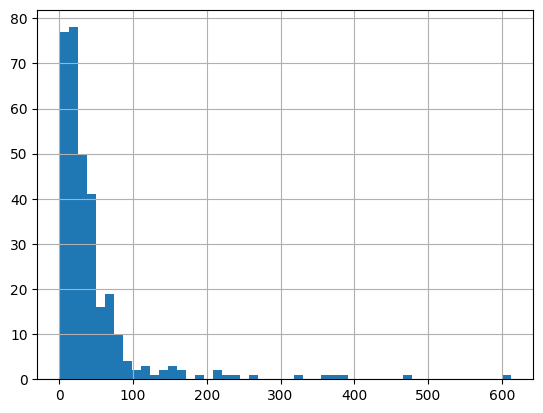

In [75]:
df_test.n_points.hist(bins=50)

In [76]:
df_test["n_points"].describe()

count    320.000000
mean      45.118750
std       66.739927
min        1.000000
25%       14.000000
50%       26.500000
75%       48.000000
max      612.000000
Name: n_points, dtype: float64

テストデータのn_pointsの分布を確認したところ、30ステップまでが多いことがわかったことから、学習データにおいても30ステップまでの距離、時間、平均速度を特徴量として追加することとする。